In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import numpy as np

In [5]:
# Hyperparameters
epochs = 100
batch_train_size = 16
batch_size = 15
initial_learning_rate = 1.5e-4
l2_regularize = 1.5e-5
l1_regularize = 1e-6

# Directories
root = 'C:/Users/kahny/ML Model'
train_dir = os.path.join(root, 'Train_Resized/')
val_dir = os.path.join(root, 'Validate_Resized/')
test_dir = os.path.join(root, 'Test_Resized/')

In [9]:
def image_gen_w_aug(train_parent_directory, validate_parent_directory, test_parent_directory):
    train_datagen = ImageDataGenerator(rescale=1/255,
                                       rotation_range=45,
                                       zoom_range=0.3,
                                       width_shift_range=0.3,
                                       height_shift_range=0.3,
                                       shear_range=0.3,
                                       horizontal_flip=True,
                                       fill_mode='nearest')

    test_datagen = ImageDataGenerator(rescale=1/255)
    val_datagen = ImageDataGenerator(rescale=1/255)

    train_generator = train_datagen.flow_from_directory(train_parent_directory,
                                                        target_size=(75, 75),
                                                        batch_size=batch_train_size,
                                                        class_mode='categorical',
                                                        shuffle=True)

    val_generator = val_datagen.flow_from_directory(validate_parent_directory,
                                                    target_size=(75, 75),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

    test_generator = test_datagen.flow_from_directory(test_parent_directory,
                                                      target_size=(75, 75),
                                                      batch_size=batch_size,
                                                      class_mode='categorical',
                                                      shuffle=False)

    return train_generator, val_generator, test_generator

train_generator, validation_generator, test_generator = image_gen_w_aug(train_dir, val_dir, test_dir)

def build_sequential_inception(input_shape):
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))

    # First Inception-like block
    model.add(Conv2D(32, (1, 1), padding='same', activation='relu'))
    model.add(Conv2D(48, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (5, 5), padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Second Inception-like block
    model.add(Conv2D(64, (1, 1), padding='same', activation='relu'))
    model.add(Conv2D(96, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (5, 5), padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Third Inception-like block
    model.add(Conv2D(128, (1, 1), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(192, (5, 5), padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Fourth Inception-like block
    model.add(Conv2D(128, (1, 1), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(192, (5, 5), padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=l1_regularize, l2=l2_regularize)))
    model.add(Dropout(0.1))
    model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=l1_regularize, l2=l2_regularize)))
    model.add(Dropout(0.1))
    model.add(Dense(3, activation='softmax'))

    return model

input_shape = (75, 75, 3)
model = build_sequential_inception(input_shape)

class CustomStopper(Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')
        if train_acc is not None and val_acc is not None:
            if train_acc >= 0.96 and val_acc >= 0.96:
                print("Stopping training as both training and validation accuracy have reached 96%.")
                self.model.stop_training = True

model.compile(optimizer=Adam(learning_rate=initial_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
custom_stopper = CustomStopper()

# Function to convert DirectoryIterator to tf.data.Dataset
def generator_to_dataset(generator):
    output_signature = (
        tf.TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 3), dtype=tf.float32)
    )
    def generator_function():
        for batch in generator:
            yield batch
    return tf.data.Dataset.from_generator(generator_function, output_signature=output_signature)

# Convert the generators to tf.data.Dataset
train_dataset = generator_to_dataset(train_generator).repeat()
validation_dataset = generator_to_dataset(validation_generator).repeat()

# Print model summary
model.summary()

# Training the model
with tf.device("/GPU:0"):
    history = model.fit(
        train_dataset,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_dataset,
        validation_steps=len(validation_generator),
        callbacks=[reduce_lr, custom_stopper]  # Ensure custom_stopper is included here
    )

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_generator, verbose=1)

training_accuracy = history.history['accuracy'][-1]
validation_accuracy = history.history['val_accuracy'][-1]
training_loss = history.history['loss'][-1]
validation_loss = history.history['val_loss'][-1]

# Print summary
print(f"\nModel Summary:")
print(f"Training Accuracy: {training_accuracy:.4f}")
print(f"Validation Accuracy: {validation_accuracy:.4f}")
print(f"Test Accuracy: {test_acc:.4f}\n")
print(f"Training Loss: {training_loss:.4f}")
print(f"Validation Loss: {validation_loss:.4f}")
print(f"Test Loss: {test_loss:.4f}\n")
print(f"Learning Rate: {initial_learning_rate}")
print(f"Epochs: {epochs}")
print(f"Steps Per Epoch: {len(train_generator)}")
print(f"Batch Size: {train_generator.batch_size}")

Found 2400 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_39 (Conv2D)              │ (None, 75, 75, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 37, 37, 32)     │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 37, 37, 48)     │        13,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 37, 37, 64)     │        76,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 18, 18, 64)     │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 18, 18, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 18, 18, 128)    │       307,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 9, 9, 128)      │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 9, 9, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 9, 9, 192)      │       614,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 4, 4, 128)      │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 4, 4, 192)      │       614,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 2, 2, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,255,283 (8.60 MB)

 Trainable params: 2,255,283 (8.60 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 35s 165ms/step - accuracy: 0.3433 - loss: 1.1128 - val_accuracy: 0.3867 - val_loss: 1.0612 - learning_rate: 1.5000e-04
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 132ms/step - accuracy: 0.4969 - loss: 1.0139 - val_accuracy: 0.5167 - val_loss: 0.9710 - learning_rate: 1.5000e-04
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 125ms/step - accuracy: 0.5469 - loss: 0.9554 - val_accuracy: 0.7667 - val_loss: 0.6198 - learning_rate: 1.5000e-04
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - accuracy: 0.6870 - loss: 0.8083 - val_accuracy: 0.8000 - val_loss: 0.5457 - learning_rate: 1.5000e-04
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - accuracy: 0.7145 - loss: 0.7181 - val_accuracy: 0.8233 - val_loss: 0.4795 - learning_rate: 1.5000e-04
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 18s 118ms/step - accuracy: 0.7653 - loss: 0.6227 - val_accuracy: 0.8433 - val_loss: 0.3851 - learning_rate: 1.5000e-04
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━

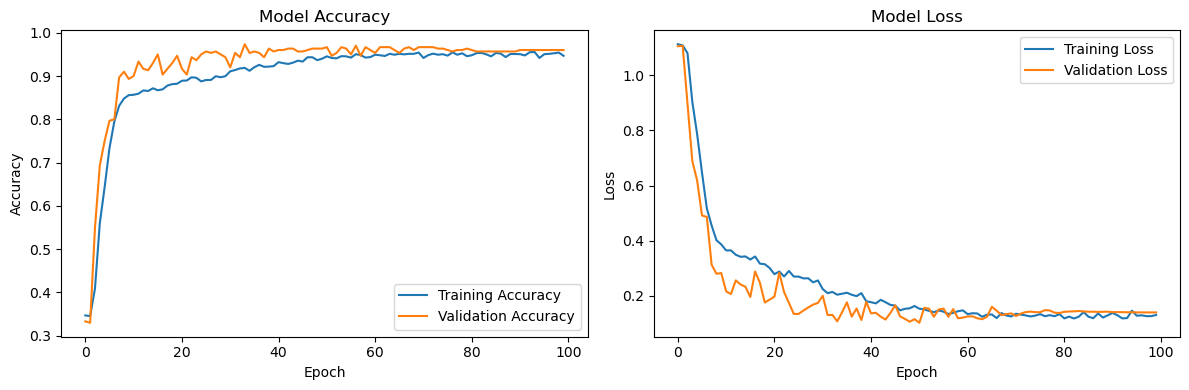

In [8]:
# Plot the accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

model.save('my_model.h5')